In [1]:
import Pkg
#Pkg.add("TikzPictures");
using TikzPictures
#Pkg.add("Combinatorics");
using Combinatorics

In [2]:
"Generate list of paths given sources (3.1)"
function paths_from_sources(source_list::Array{Char})
    L = length(source_list)
    path_list = Array{Tuple{Char,Char}}(undef,(L*(L-1))÷2)
    ind = 1
    for i=1:L
        for j=i+1:L
            path_list[ind] = (source_list[i],source_list[j])
            ind += 1
        end
    end
    return path_list
end

paths_from_sources

In [3]:
"Generate edges by attempting to add more paths to them"
function edges_recursive(selected::Vector{Int8},path_list::Vector{Tuple{Char,Char}},source_list::Array{Char},in_chars::Set{Char},out_chars::Set{Char})
    # if a decision has been made about all the paths
    # end the recursion
    if length(selected) == length(path_list)
        if all(selected .== 0)
            return []
        end
        return [selected]
    end

    possible_edges = Vector{Vector{Int8}}(undef,0)
    # the next path upon which a decision must be made
    next_path = path_list[length(selected)+1]

    # if the path is allowed to point in the same direction
    if !(next_path[1] in out_chars) && !(next_path[2] in in_chars)
        new_selected = vcat(selected,Vector{Int8}([1]))
        new_in = union(in_chars,[next_path[1]])
        new_out = union(out_chars,[next_path[2]])
        edges = edges_recursive(new_selected,path_list,source_list,new_in,new_out)
        append!(possible_edges,edges)
    end

    # if the path is allowed to point in the reverse direction
    if !(next_path[1] in in_chars) && !(next_path[2] in out_chars)
        new_selected = vcat(selected,Vector{Int8}([-1]))
        new_in = union(in_chars,[next_path[2]])
        new_out = union(out_chars,[next_path[1]])
        edges = edges_recursive(new_selected,path_list,source_list,new_in,new_out)
        append!(possible_edges,edges)
    end

    # choosing not to include the next path
    new_selected = vcat(selected,Vector{Int8}([0]))
    edges = edges_recursive(new_selected,path_list,source_list,in_chars,out_chars)
    append!(possible_edges,edges)

    return possible_edges
end

"Generate possible edges given possible paths and sources (3.2)"
function edges_from_paths(path_list::Array{Tuple{Char,Char}},source_list::Array{Char})
    return edges_recursive(Vector{Int8}([]),path_list,source_list,Set{Char}(),Set{Char}())
end

edges_from_paths

In [4]:
"Generate possible vertices from edges (3.3)"
function vertices_from_edges(edge_list::Vector{Vector{Int8}},path_list::Array{Tuple{Char,Char}},source_list::Array{Char})
    vertex_list = Vector{Array{Vector{Int8}}}([])

    # loop over all possible 'input' edges
    for i=1:length(edge_list)
        edge = edge_list[i]

        # edges that only have 1 path cannot be split
        if sum(abs.(edge)) == 1
            continue
        end

        out_chars = Vector{Char}([])
        out_char_corresponding_inds = []
        # generating a list of treminals this vertex connects to
        # and identifying corresponding paths to make sure the split is consistent
        for j=1:length(edge)
            if edge[j]==0
                continue
            end

            if edge[j]==1
                index = findfirst(out_chars .== path_list[j][2])
                if index==nothing
                    push!(out_chars,path_list[j][2])
                    push!(out_char_corresponding_inds,[j])
                    continue
                end
                push!(out_char_corresponding_inds[index],j)
            end

            if edge[j]==-1
                index = findfirst(out_chars .== path_list[j][1])
                if index==nothing
                    push!(out_chars,path_list[j][1])
                    push!(out_char_corresponding_inds,[j])
                    continue
                end
                push!(out_char_corresponding_inds[index],j)
            end
        end

        if length(out_chars) == 1
            continue
        end

        # split the terminals (and corresponding paths) in all possible ways
        for c in combinations(2:length(out_chars))
            left_char_inds = append!([1],setdiff(2:length(out_chars),c))
            right_char_inds = c

            left_path_inds = vcat([out_char_corresponding_inds[j] for j in left_char_inds]...)
            right_path_inds = vcat([out_char_corresponding_inds[j] for j in right_char_inds]...)

            vertex = Array{Vector{Int8}}(undef,3)
            vertex[1] = edge
            vertex[2] = [j in left_path_inds ? -edge[j] : 0 for j=1:length(edge)]
            vertex[3] = [j in right_path_inds ? -edge[j] : 0 for j=1:length(edge)]
            push!(vertex_list,vertex)
        end
    end

    return vertex_list
end

vertices_from_edges

In [5]:
"Generate matrices used in vertex set generation"
function splitting_compatibility_and_requirement(vertex_list,path_list)
    L = length(vertex_list)

    # keeps track of constraints 3.4.a, 3.4.b, 3.4.c
    compatibility = Array{Bool}(undef,(L,L))

    # keeps track of a special case of edges coming in pairs
    # if a pair of paths merges at some point, it must split later
    requirement = Array{Bool}(undef,(L,L))

    path_count = length(path_list)

    # for each pair of vertices
    for i=1:length(vertex_list)
        compatibility[i,i] = false
        requirement[i,i] = false
        for j=(i+1):length(vertex_list)
            v1 = vertex_list[i]
            v2 = vertex_list[j]

            compatibility_flag = true
            requirement_flag = false

            # they are incompatible if the same pair of paths split (3.4.a)
            # they are incompatible if the same pair of paths go in opposite directions (3.4.b)
            for p1=1:path_count
                for p2=1:path_count
                    if v1[2][p1]!=0 && v1[3][p2]!=0
                        if v2[2][p1]!=0 && v2[3][p2]!=0
                            if (v1[2][p1],v1[3][p2]) == (v2[2][p1],v2[3][p2]) ||
                                (v1[2][p1]*v1[3][p2]) != (v2[2][p1]*v2[3][p2])
                                compatibility_flag = false
                            else
                                requirement_flag = true
                            end
                        elseif v2[3][p1]!=0 && v2[2][p2]!=0
                            if (v1[2][p1],v1[3][p2]) == (v2[3][p1],v2[2][p2]) ||
                                (v1[2][p1]*v1[3][p2]) != (v2[3][p1]*v2[2][p2])
                                compatibility_flag = false
                            else
                                requirement_flag = true
                            end
                        end
                    end
                end
            end

            # if the vertices are still marked as compatible, check constraint 3.4.c
            if compatibility_flag
                v1_only_paths = [path_list[i] for i=1:path_count if v1[1][i]!=0 && v2[1][i]==0]
                v2_only_paths = [path_list[i] for i=1:path_count if v2[1][i]!=0 && v1[1][i]==0]

                for n=2:min(length(v1_only_paths),length(v2_only_paths))
                    v1_path_combinations = combinations(v1_only_paths,n)
                    v2_path_combinations = combinations(v2_only_paths,n)

                    for c1 in v1_path_combinations
                        for c2 in v2_path_combinations
                            v1_endpoints = [p[j] for p in c1 for j=1:2]
                            v2_endpoints = [p[j] for p in c2 for j=1:2]

                            if sort(v1_endpoints) == sort(v2_endpoints)
                                compatibility_flag = false
                                requirement_flag = false
                                continue
                            end
                        end
                    end

                    if !compatibility_flag
                        continue
                    end
                end
            end

            compatibility[i,j] = compatibility_flag
            compatibility[j,i] = compatibility_flag
            requirement[i,j] = requirement_flag
            requirement[j,i] = requirement_flag
        end
    end

    return compatibility,requirement
end

"Generate a dictionary used for ensuring pairing of edges"
function connecting_edge_requirement_dictionary(vertex_list)
    dict = Dict{Vector{Int8},Vector{Int}}()

    for i=1:length(vertex_list)
        v = vertex_list[i]

        for j=1:3
            e = v[j]
            has_key = get(dict,e,false)!=false
            if has_key
                push!(dict[e],i)
            else
                dict[e] = [i]
            end
        end
    end

    return dict
end

"Recursively generate subsets of vertices given constraints and pairing requirements (3.4)"
function recursive_set_calculation(loose_edges,selected,remaining,compatibility,requirement,edge_dictionary,vertex_list)
    available = selected .|| remaining

    # if a proper pairing of edges is no longer possible, this subset is invalid
    for i in findall(selected)
        r = requirement[i,:]
        if any(r) && !any(r .&& available)
            return []
        end
    end
    for e in loose_edges
        possible_vertices = get(edge_dictionary,-e,[])
        if !any(remaining[possible_vertices])
            return []
        end
    end

    ind = findfirst(remaining)

    # if there are no remaining vertices compatible with constraints, this is the final subset
    if ind==nothing
        return [selected]
    end

    # do recursion step for if the next vertex is included
    included_selected = copy(selected)
    included_selected[ind] = true
    included_remaining = remaining .&& compatibility[ind,:]
    included_remaining[ind] = false

    included_loose_edges = copy(loose_edges)
    for e in vertex_list[ind]
        if (-e) in included_loose_edges
            match = [edge==(-e) for edge in included_loose_edges]
            corresponding_index = findfirst(match)
            popat!(included_loose_edges,corresponding_index)
        else
            push!(included_loose_edges,e)
        end
    end

    included_sets = recursive_set_calculation(  included_loose_edges,
                                                included_selected,
                                                included_remaining,
                                                compatibility,
                                                requirement,
                                                edge_dictionary,
                                                vertex_list)

    # do recursion step for if the next vertex is excluded
    excluded_selected = selected
    excluded_loose_edge = loose_edges
    excluded_remaining = copy(remaining)
    excluded_remaining[ind] = false
    
    excluded_sets = recursive_set_calculation(  excluded_loose_edge,
                                                excluded_selected,
                                                excluded_remaining,
                                                compatibility,
                                                requirement,
                                                edge_dictionary,
                                                vertex_list)

    return vcat(included_sets,excluded_sets)
end

"Generate starting edges"
function starting_edges_from_paths(path_list,source_list)
    edges = Vector{Vector{Int8}}(undef,length(source_list))
    for i=1:length(source_list)
        edges[i] = zeros(Int8,length(path_list))
        for j=1:length(path_list)
            if path_list[j][1]==source_list[i]
                edges[i][j] = -1
            elseif path_list[j][2]==source_list[i]
                edges[i][j] = 1
            end
        end
    end

    return edges
end

starting_edges_from_paths

In [6]:
"Connect vertices at all appropriate edges"
function connect_vertices(vertices,starting_edges)
    dict = Dict{Vector{Int8},Tuple{Vector{Tuple{Int,Int}},Vector{Tuple{Int,Int}}}}()

    # count how many of each type of edge is present
    for i=1:length(starting_edges)
        e = starting_edges[i]
        dict[e] = ([(-i,i)],[])
    end
    for i=1:length(vertices)
        v = vertices[i]

        for j=1:3
            e = v[j]
            direct_entry = get(dict,e,false)
            conjugate_entry = get(dict,-e,false)
            if (direct_entry != false)
                push!( dict[e][1] , (i,j) )
            elseif (conjugate_entry != false)
                push!( dict[-e][2] , (i,j) )
            else
                dict[e] = ([(i,j)],[])
            end
        end
    end

    dict_keys = collect(keys(dict))
    conjugate_indices = [dict[k][2] for k in dict_keys]

    # pair edges in all possible ways
    conjugate_options = [collect(permutations(c)) for c in conjugate_indices]

    # if there is only a single pairing for each edge, output the only option
    if prod(length.(conjugate_indices)) == 1
        out_connections = Array{Array{Int}}(undef,1)
        out_connections[1] = Array{Int}(undef,(length(vertices),3))
        for k=1:length(dict_keys)
            left = dict[dict_keys[k]][1][1]
            right = dict[dict_keys[k]][2][1]
            if left[1] > 0
                out_connections[1][left[1],left[2]] = right[1]
            end
            if right[1] > 0
                out_connections[1][right[1],right[2]] = left[1]
            end
        end
        return out_connections
    end

    # direct product of all possible pairing for all edges
    connection_possibilities = reduce(vcat,Iterators.product(conjugate_options...) |> collect)

    # write down all possible connections
    out_connections = Array{Array{Int}}(undef,length(connection_possibilities))
    for i=1:length(connection_possibilities)
        c = connection_possibilities[i]
        out_connections[i] = Array{Int}(undef,(length(vertices),3))
        for k=1:length(dict_keys)
            for j=1:length(dict[dict_keys[k]][1])
                left = dict[dict_keys[k]][1][j]
                right = c[k][j]
                if left[1] > 0
                    out_connections[i][left[1],left[2]] = right[1]
                end
                if right[1] > 0
                    out_connections[i][right[1],right[2]] = left[1]
                end
            end
        end
    end

    return out_connections
end

"Validate connected vertices by making sure they do not have internal path cycles"
function validate_connection(vertices,connection,path_count)
    for p=1:path_count
        relevant_vertices = Set{Int}([])
        for v=1:length(vertices)
            if vertices[v][1][p] != 0
                push!(relevant_vertices,v)
            end
        end
        v = pop!(relevant_vertices)
        queue = [v]
        used = []
        while length(queue) != 0
            cur = pop!(queue)
            push!(used,cur)

            for i=1:3
                edge = vertices[cur][i]
                if edge[p] != 0
                    connected = connection[cur,i]
                    if connected in relevant_vertices
                        push!(queue,connected)
                        delete!(relevant_vertices,connected)
                    elseif (connected > 0) && !(connected in used)
                        return false
                    end
                end
            end
        end
        if length(relevant_vertices) > 0
            return false
        end
    end

    return true
end

"Generate valid graphs using vertex subsets (3.5)"
function generate_valid_graphs(vertex_sets,vertex_list,starting_edges,path_count)
    graphs = Vector{Tuple{Vector{Array{Vector{Int8}}},Array{Int64}}}(undef,0)
    for s in vertex_sets
        vertices = vertex_list[s]
        connections = connect_vertices(vertices,starting_edges)
        for c in connections
            if validate_connection(vertices,c,path_count)
                push!(graphs,(vertices,c))
            end
        end
    end
    return graphs
end

generate_valid_graphs

In [7]:
"Calculate weights for how 'close' each vertex is to sources for use in plotting"
function plotting_vertex_source_weights(graph,source_list,path_list,starting_edges)
    vertices = graph[1]
    connections = graph[2]

    weights = zeros(Float64,(length(vertices),length(source_list)))

    for i=1:length(path_list)
        relevant_vertex_indices = [v_ind for v_ind=1:length(vertices) if vertices[v_ind][1][i] != 0]
        total_dist = length(relevant_vertex_indices)+1

        start_source_index = findfirst(source_list.==path_list[i][1])
        end_source_index = findfirst(source_list.==path_list[i][2])

        start_distances = Array{Int}(undef,length(vertices))
        end_distances = Array{Int}(undef,length(vertices))

        starting_edge = starting_edges[start_source_index]

        cur_vertex_ind = [v_ind for v_ind in relevant_vertex_indices if (-starting_edge) in vertices[v_ind]][1]
        start_dist = 1
        end_dist = total_dist - start_dist
        start_distances[cur_vertex_ind] = start_dist
        end_distances[cur_vertex_ind] = end_dist
        edge_ind = findfirst([e[i] for e in vertices[cur_vertex_ind]].==-1)
        while connections[cur_vertex_ind,edge_ind] > 0
            cur_vertex_ind = connections[cur_vertex_ind,edge_ind]
            start_dist += 1
            end_dist -= 1
            start_distances[cur_vertex_ind] = start_dist
            end_distances[cur_vertex_ind] = end_dist
            edge_ind = findfirst([e[i] for e in vertices[cur_vertex_ind]].==-1)
        end

        for v_ind in relevant_vertex_indices
            s = start_distances[v_ind]
            e = end_distances[v_ind]
            weights[v_ind,start_source_index] += 1/s
            weights[v_ind,end_source_index] += 1/e
        end
    end

    for i=1:size(weights)[1]
        weights[i,:] *= 1/sum(weights[i,:])
    end

    return weights
end

"Generate a tikz string that can be used to plot the graph"
function tikz_string_graph(graph,source_list,path_list,starting_edges,source_positions,vertex_nums=false)
    tikz_str = L""

    num_vertices = length(graph[1])
    vertex_position_weights = plotting_vertex_source_weights(graph,source_list,path_list,starting_edges)
    node_positions = Dict{Int,Vector{Float64}}([])
    for s=1:length(source_positions)
        node_positions[-s] = source_positions[s]
        tikz_str *= L"\node (%$(-s)) at (%$(source_positions[s][1]),%$(source_positions[s][2])) {\large %$(source_list[s])};"
    end
    for v=1:num_vertices
        node_positions[v] = [0.0,0.0]
        for s=1:length(source_list)
            node_positions[v] += source_positions[s]*vertex_position_weights[v,s]
        end
        if vertex_nums
            tikz_str *= L"\node (%$(v)) at (%$(node_positions[v][1]),%$(node_positions[v][2])) {\large %$v};"
        else
            tikz_str *= L"\node[inner sep=0pt] (%$(v)) at (%$(node_positions[v][1]),%$(node_positions[v][2])) {};"
        end
    end
    vertex_angles = Array{Float64}(undef,num_vertices)

    position_list = values(node_positions)
    position_set = Set(position_list)
    
    for v=1:num_vertices
        vertex_pos = node_positions[v]
        incoming_pos = node_positions[graph[2][v,1]]
        dy = vertex_pos[2]-incoming_pos[2]
        dx = vertex_pos[1]-incoming_pos[1]
        vertex_angles[v] = atan(dy,dx)*180/pi
    end

    for v=1:num_vertices
        for i=1:3
            if (graph[2][v,i] > v)
                continue
            end
            if i==1
                out_str = "out=$(180+vertex_angles[v])"
            else
                out_str = "out=$(vertex_angles[v])"
            end
            path_count = sum(abs.(graph[1][v][i]))
            paths = join([p[1]*p[2] for p in path_list[graph[1][v][i] .!= 0]],",")
            loose_str = "looseness=1"
            out_center = "($v)"
            in_center = "($(graph[2][v,i]))"
            if graph[2][v,i]<0
                style_str = "[edge node={node {\\tiny $paths}}]"
                edge_str = L"\draw %$(out_center) to%$(style_str) %$(in_center);"
                tikz_str *= edge_str
            else
                in_index = graph[2][v,i]
                in_edge = findfirst(graph[2][in_index,:].==v)
                if in_edge==1
                    in_str = "in=$(180+vertex_angles[in_index])"
                else
                    in_str = "in=$(vertex_angles[in_index])"
                end
                style_str = "[$out_str, $in_str, $loose_str, edge node={node {\\tiny $paths}}]"
                edge_str = L"\draw %$(out_center) to%$(style_str) %$(in_center);"
                tikz_str *= edge_str
            end
        end
    end

    return tikz_str,length(position_set) != length(position_list)
end

# Generate an image for a graph, avoiding overlapping vertices if possible
function generate_image(g,vertex_nums=false,display_bool=true)
    source_positions = [
    [0.0,0.0],
    [0.0,20.0],
    [20.0,0.0],
    [20.0,20.0]
    ]
    tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions,vertex_nums)
    if stacked
        source_positions = [
        [20.0,0.0],
        [0.0,20.0],
        [0.0,0.0],
        [20.0,20.0]
        ]
        tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions,vertex_nums)
    end
    if stacked
        source_positions = [
        [0.0,0.0],
        [0.0,20.0],
        [20.0,20.0],
        [20.0,0.0]
        ]
        tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions,vertex_nums)
    end
    tp = TikzPicture(tikz_string
        , options="scale=0.5", preamble="")
    if display_bool
        display(tp)
    end
    return tp
end

generate_image (generic function with 3 methods)

In [8]:
# Identify inequalities required between edge weights for graph to be valid
function edge_constraints(graph,source_list,path_list)
    num_vertices = length(graph[1])

    constraints = Vector{Tuple{Set{Tuple{Int,Int8}},Set{Tuple{Int,Int8}}}}()

    for i=1:length(path_list)
        path = path_list[i]

        start_source = findfirst(source_list .== path[1])
        end_source = findfirst(source_list .== path[2])

        start_vertex = findfirst([(-start_source in graph[2][i,:]) for i=1:num_vertices])
        end_vertex = findfirst([(-end_source in graph[2][i,:]) for i=1:num_vertices])

        start_source_direction = findfirst(graph[2][start_vertex,:] .== -start_source)

        routes = Vector{Tuple{Vector{Tuple{Int,Int8}},Set{Int}}}(
            [
                (
                    [(-start_source,-1),(start_vertex,start_source_direction)],
                    Set{Int}([start_vertex])
                )
            ])
        completed_routes = Vector{Vector{Tuple{Int,Int8}}}([])
        correct_route = Vector{Tuple{Int,Int8}}([])

        while length(routes) != 0
            cur_route,cur_used = pop!(routes)
            last_vertex = cur_route[end][1]
            if last_vertex == end_vertex
                if all([graph[1][a[1]][a[2]][i]==1 for a in cur_route[2:end]])
                    correct_route = cur_route
                else
                    push!(completed_routes,cur_route)
                end
            else
                for i=1:3
                    new_vertex = graph[2][last_vertex,i]
                    if new_vertex > 0 && !(new_vertex in [a[1] for a in cur_route]) # && !(new_vertex in cur_used)
                        new_route = copy(cur_route)
                        new_direction = findfirst(graph[2][new_vertex,:] .== last_vertex)
                        push!(new_route,(new_vertex,new_direction))
                        
                        new_used = copy(cur_used)
                        union!(new_used,graph[2][last_vertex,:])
                        union!(new_used,[new_vertex])
                        
                        push!(routes,(new_route,new_used))
                    end
                end
            end
        end

        correct_set = Set{Tuple{Int,Int8}}(correct_route)
        for route in completed_routes
            route_set = Set{Tuple{Int,Int8}}(route)
            correct_exclusive = setdiff(correct_set,route_set)
            incorrect_exclusive = setdiff(route_set,correct_set)
            push!(constraints,(correct_exclusive,incorrect_exclusive))
        end
    end

    return constraints
end

# Generate a metric space in which the graph is optimal by fulfilling edge weight inequalities
function generate_personalized_metric_space(graph,source_list,path_list)
    lengths = ones(Int,size(graph[2]))

    constraints = edge_constraints(graph,source_list,path_list)

    reset = false
    iteration_count = 0

    while (iteration_count == 0 || reset) && iteration_count < 20
        reset = false
        for c in constraints
            correct_route = sum([lengths[a...] for a in c[1]])
            incorrect_route = sum([lengths[a...] for a in c[2]])
            if incorrect_route <= correct_route
                increment = ceil(Int,(1+correct_route-incorrect_route)/length(c[2]))
                for a in c[2]
                    vertex_ind = a[1]
                    vertex_dir = a[2]
                    lengths[vertex_ind,vertex_dir] += increment

                    connected_ind = graph[2][vertex_ind,vertex_dir]
                    connected_dir = findfirst(graph[2][connected_ind,:].==vertex_ind)
                    lengths[connected_ind,connected_dir] += increment
                end
                reset = true
            end
        end
        iteration_count += 1
    end

    #display(lengths)

    if iteration_count == 20
        return lengths,false
    end

    return lengths,true
end

generate_personalized_metric_space (generic function with 1 method)

In [9]:
# Deciding number of sources, and names for display later
source_list = ['A','B','C','D']

# Generating paths from pairs of sources
path_list = paths_from_sources(source_list)

# Generating edges from compatible combinations/directions of paths
edge_list = edges_from_paths(path_list,source_list)

# Generating edges that leave the sources
starting_edges = starting_edges_from_paths(path_list,source_list)

# Generating vertices from appropriate choices of edges and path splitting
vertex_list = vertices_from_edges(edge_list,path_list,source_list)

# Generating constraints for which vertices can be used together
c,r = splitting_compatibility_and_requirement(vertex_list,path_list)
e = connecting_edge_requirement_dictionary(vertex_list)

# Generating valid subsets of vertices
vertex_sets = recursive_set_calculation(starting_edges,zeros(Bool,length(vertex_list)),ones(Bool,length(vertex_list)),c,r,e,vertex_list)

# Generating valid graphs using the subsets
graph_list = generate_valid_graphs(vertex_sets,vertex_list,starting_edges,length(path_list))

personal_metric_generation = [generate_personalized_metric_space(g,source_list,path_list) for g in graph_list]
all_metrics_exist = all([a[2] for a in personal_metric_generation])
personal_metrics = [a[1] for a in personal_metric_generation]

println("source_list: $source_list")
println("path_list: $path_list")
println("# of edges: $(length(edge_list))")
println("# of vertices: $(length(vertex_list))")
println("# of vertex subsets: $(length(vertex_sets))")
println("# of graphs: $(length(graph_list))")
println("All graphs optimal: $all_metrics_exist")

source_list: ['A', 'B', 'C', 'D']
path_list: [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
# of edges: 86
# of vertices: 66
# of vertex subsets: 894
# of graphs: 678
All graphs optimal: true


Displaying data for graph 125
Vertices:

8-element Vector{Array{Vector{Int8}}}:
 [[1, 1, 1, 0, 0, 0], [-1, 0, -1, 0, 0, 0], [0, -1, 0, 0, 0, 0]]
 [[1, 0, 1, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, -1, 0, 0, 0]]
 [[-1, 0, 0, 1, 1, 0], [1, 0, 0, 0, -1, 0], [0, 0, 0, -1, 0, 0]]
 [[-1, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0], [0, 0, 0, 0, -1, 0]]
 [[0, -1, 0, -1, 0, 1], [0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, -1]]
 [[0, 0, -1, 0, -1, -1], [0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1]]
 [[0, 0, -1, 0, -1, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0]]
 [[0, 0, 0, -1, 0, 1], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, -1]]

Connections:

8×3 Matrix{Int64}:
 -1  2  5
  1  4  7
 -2  4  8
  3  2  7
 -3  1  8
 -4  7  8
  6  2  4
  5  3  6

Metric for optimality:

8×3 Matrix{Int64}:
 1  2  3
 2  2  2
 1  2  4
 2  2  2
 1  3  2
 1  1  3
 1  2  2
 2  4  3

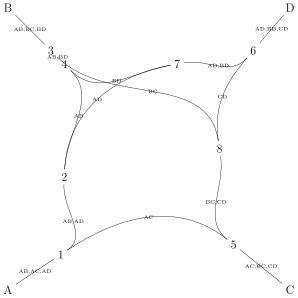

In [10]:
graph_number = rand(1:678)

g = graph_list[graph_number]

println("Displaying data for graph $graph_number")

print("Vertices:")
display(g[1])

print("Connections:")
display(g[2])

print("Metric for optimality:")
display(personal_metrics[graph_number])

generate_image(g,true,true)
println("")

In [11]:
# This codeblock can be used to filter the graphs
# by symmetry groups based on the first split at each terminal

# There are 3^4 = 81 choices for how these splits occur
# split between 6 symmetry groups based on permuting vertex labels
# A->B, B->A, C->D, D->C accounts for 3 choices
# A->B, B->A, C->A, D->C accounts for 24 choices
# A->B, B->A, C->A, D->B accounts for 12 choices
# A->B, B->A, C->A, D->A accounts for 12 choices
# A->B, B->C, C->A, D->A accounts for 24 choices
# A->B, B->C, C->D, D->A accounts for 6 choices
"""
A_split = 'D'
B_split = 'A'
C_split = 'B'
D_split = 'C'

if A_split == 'B'
    v1 = [ [1,1,1,0,0,0] , [-1,0,0,0,0,0] , [0,-1,-1,0,0,0] ]
elseif A_split == 'C'
    v1 = [ [1,1,1,0,0,0] , [-1,0,-1,0,0,0] , [0,-1,0,0,0,0] ]
elseif A_split == 'D'
    v1 = [ [1,1,1,0,0,0] , [-1,-1,0,0,0,0] , [0,0,-1,0,0,0] ]
end

if B_split == 'A'
    v2 = [ [-1,0,0,1,1,0] , [1,0,0,0,0,0] , [0,0,0,-1,-1,0] ]
elseif B_split == 'C'
    v2 = [ [-1,0,0,1,1,0] , [1,0,0,0,-1,0] , [0,0,0,-1,0,0] ]
elseif B_split == 'D'
    v2 = [ [-1,0,0,1,1,0] , [1,0,0,-1,0,0] , [0,0,0,0,-1,0] ]
end

if C_split == 'A'
    v3 = [ [0,-1,0,-1,0,1] , [0,1,0,0,0,0], [0,0,0,1,0,-1] ]
elseif C_split == 'B'
    v3 = [ [0,-1,0,-1,0,1] , [0,1,0,0,0,-1], [0,0,0,1,0,0] ]
elseif C_split == 'D'
    v3 = [ [0,-1,0,-1,0,1] , [0,1,0,1,0,0], [0,0,0,0,0,-1] ]
end

if D_split == 'A'
    v4 = [ [0,0,-1,0,-1,-1], [0,0,1,0,0,0], [0,0,0,0,1,1] ]
elseif D_split == 'B'
    v4 = [ [0,0,-1,0,-1,-1], [0,0,1,0,0,1], [0,0,0,0,1,0] ]
elseif D_split == 'C'
    v4 = [ [0,0,-1,0,-1,-1], [0,0,1,0,1,0], [0,0,0,0,0,1] ]
end

V = [v1,v2,v3,v4]

length([g for g in graph_list if all([v in g[1] for v in V])])"""

"A_split = 'D'\nB_split = 'A'\nC_split = 'B'\nD_split = 'C'\n\nif A_split == 'B'\n    v1 = [ [1,1,1,0,0,0] , [-1,0,0,0,0,0] , [0,-1,-1,0,0,0] ]\nelseif A_split == 'C'\n    v1 = [ [1,1,1,0,0,0] , [-1,0,-1,0,0,0] , [0,-1,0,0,0,0] ]\nelseif A_split == 'D'\n    v1 = [ [1,1,1,0,0,0] , [" ⋯ 600 bytes ⋯ "0], [0,0,0,0,1,1] ]\nelseif D_split == 'B'\n    v4 = [ [0,0,-1,0,-1,-1], [0,0,1,0,0,1], [0,0,0,0,1,0] ]\nelseif D_split == 'C'\n    v4 = [ [0,0,-1,0,-1,-1], [0,0,1,0,1,0], [0,0,0,0,0,1] ]\nend\n\nV = [v1,v2,v3,v4]\n\nlength([g for g in graph_list if all([v in g[1] for v in V])])"

In [12]:
# This codeblock saves an svg graph to folder /graph_saves/
"""
for i=1:length(graph_list)
    g = graph_list[i]
    source_positions = [
    [0.0,0.0],
    [0.0,20.0],
    [20.0,0.0],
    [20.0,20.0]
    ]
    tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions)
    if stacked
        source_positions = [
        [20.0,0.0],
        [0.0,20.0],
        [0.0,0.0],
        [20.0,20.0]
        ]
        tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions)
    end
    if stacked
        source_positions = [
        [0.0,0.0],
        [0.0,20.0],
        [20.0,20.0],
        [20.0,0.0]
        ]
        tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions)
    end
    if stacked
        println(i)
    end
    tp = TikzPicture(tikz_string
    , options="scale=0.5", preamble="")
    save(SVG("graph_saves/graph_\$i.svg"), tp)
end"""

"for i=1:length(graph_list)\n    g = graph_list[i]\n    source_positions = [\n    [0.0,0.0],\n    [0.0,20.0],\n    [20.0,0.0],\n    [20.0,20.0]\n    ]\n    tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions)\n    if stacked\n        sour" ⋯ 359 bytes ⋯ " tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions)\n    end\n    if stacked\n        println(i)\n    end\n    tp = TikzPicture(tikz_string\n    , options=\"scale=0.5\", preamble=\"\")\n    save(SVG(\"graph_saves/graph_\$i.svg\"), tp)\nend"